In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler

In [3]:
import yfinance as yf
stock_symbol = 'GOOG'
data = yf.download(tickers=stock_symbol,period='2y',interval='1d')
data = data.reset_index()
data.tail()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
500,2022-03-17,2666.419922,2694.790039,2654.379883,2692.010010,2692.010010,1199700
501,2022-03-18,2677.679932,2738.270020,2658.639893,2736.030029,2736.030029,2291100
502,2022-03-21,2736.949951,2751.649902,2692.229980,2729.570068,2729.570068,1331600
503,2022-03-22,2730.000000,2830.000000,2730.000000,2805.550049,2805.550049,1488800
504,2022-03-23,2782.770020,2800.500000,2763.330078,2770.070068,2770.070068,1263800


In [4]:
test_size = 60
data_train = data[:-test_size]
data_test = data[-test_size:]
data.shape,data_train.shape,data_test.shape

((505, 7), (445, 7), (60, 7))

In [5]:
training_data = data_train.drop(['Date','Adj Close'],axis=1)
training_data.head()

,Open,High,Low,Close,Volume
0,1103.770020,1135.000000,1090.619995,1134.459961,3344500
1,1126.469971,1148.900024,1086.010010,1102.489990,4081500
2,1111.800049,1169.969971,1093.530029,1161.750000,3571700
3,1125.670044,1150.670044,1105.910034,1110.709961,3208500
4,1125.040039,1151.630005,1096.479980,1146.819946,2574100


In [6]:
scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)
training_data[0]

array([0.0028672 , 0.00598913, 0.00563622, 0.01908885, 0.75275595])

In [7]:
# Preparing the training set
x_train = []
y_train = []

for i in range(test_size, training_data.shape[0]):
    x_train.append(training_data[i-test_size:i])
    y_train.append(training_data[i,0])
# last 60 days will be the training set - X
# 31st day is the target value - Y

x_train = np.array(x_train)
y_train = np.array(y_train)

x_train.shape,y_train.shape
# 385 rows
# 60 columns
# 5 dimentional data

((385, 60, 5), (385,))

In [8]:
# Preparing the testing data
past_test_days = data_train.tail(test_size)
df = past_test_days.append(data_test,ignore_index = True)
df = df.drop(['Date','Adj Close'],axis='columns')
df.shape, df.head()

C:\Users\Karen Pinto\AppData\Local\Temp\ipykernel_18084\1844731096.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = past_test_days.append(data_test,ignore_index = True)


((120, 5),
           Open         High          Low        Close   Volume
 0  2671.090088  2741.419922  2667.550049  2729.250000  1419400
 1  2713.989990  2714.000000  2623.330078  2675.300049  1576500
 2  2680.000000  2747.239990  2680.000000  2723.540039  1206300
 3  2692.510010  2757.040039  2689.729980  2747.080078   988200
 4  2777.260010  2803.089111  2771.260010  2783.709961   912500)

In [9]:
df = scaler.transform(df)
df[0]

array([0.81844062, 0.84552586, 0.82783614, 0.85131245, 0.26934184])

In [10]:
x_test = []
y_test = []

for i in range(test_size,df.shape[0]):
    x_test.append(df[i-test_size:i])
    y_test.append(df[i,0])

x_test, y_test = np.array(x_test),np.array(y_test)
x_test.shape, y_test.shape

((60, 60, 5), (60,))

In [11]:
# Defining the scaling label
# below is the scaling label, 
# therefore we need to divide our y_pred with the below scaling value it used to scale the data
scaler.scale_

array([5.20361758e-04, 5.22613496e-04, 5.21392760e-04, 5.21838980e-04,
       2.51111167e-07])

In [12]:
scale = 1/8.50296711e-04
scale

1176.0600588751424

In [13]:
y_test = y_test*scale

### LSTM - Long Short-Term Memory

In [14]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [15]:
x_train.shape[1],x_train.shape[2]

(60, 5)

In [16]:
regression = Sequential()

# 1st layer
regression.add(LSTM(units=40,activation='relu',return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
regression.add(Dropout(0.2))

# 2nd layer
regression.add(LSTM(units=60,activation='relu',return_sequences=True))
regression.add(Dropout(0.2))

# 3rd layer
regression.add(LSTM(units=80,activation='relu',return_sequences=True))
regression.add(Dropout(0.2))

# Final layer
regression.add(LSTM(units=120,activation='relu'))
regression.add(Dropout(0.5))

regression.add(Dense(units=1))

regression.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 40)            7360      
                                                                 
 dropout (Dropout)           (None, 60, 40)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 60)            24240     
                                                                 
 dropout_1 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 80)            45120     
                                                                 
 dropout_2 (Dropout)         (None, 60, 80)            0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

In [17]:
regression.compile(optimizer='adam',loss='mean_squared_error')

In [18]:
def forecast():
    regression.fit(x_train,y_train,epochs=300,batch_size=32)
    y_pred = regression.predict(x_test)
    y_pred = y_pred*scale
    return y_pred

In [19]:
result_forecast = []
simulation = 10
for i in range(simulation):
    result_forecast.append(forecast())

Epoch 1/300
13/13 [==============================] - 4s 86ms/step - loss: 0.2074
Epoch 2/300
13/13 [==============================] - 1s 93ms/step - loss: 0.0778
Epoch 3/300
13/13 [==============================] - 1s 91ms/step - loss: 0.0270
Epoch 4/300
13/13 [==============================] - 1s 95ms/step - loss: 0.0268
Epoch 5/300
13/13 [==============================] - 1s 93ms/step - loss: 0.0255
Epoch 6/300
13/13 [==============================] - 1s 93ms/step - loss: 0.0190
Epoch 7/300
13/13 [==============================] - 1s 91ms/step - loss: 0.0163
Epoch 8/300
13/13 [==============================] - 1s 96ms/step - loss: 0.0135
Epoch 9/300
13/13 [==============================] - 1s 90ms/step - loss: 0.0113
Epoch 10/300
13/13 [==============================] - 1s 92ms/step - loss: 0.0113
Epoch 11/300
13/13 [==============================] - 1s 96ms/step - loss: 0.0151
Epoch 12/300
13/13 [==============================] - 1s 93ms/step - loss: 0.0122
Epoch 13/300
13/13 [=====

#### Accuracy

In [20]:
# RMSE - Root Mean Squared Error 
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = np.sqrt(np.mean(np.square(predict-real)))
    return percentage * 100
mean_accuracy = []
for i in range(simulation):
    mean_accuracy.append(calculate_accuracy(y_test, result_forecast[i]))

mean_accuracy

[90.85258800788448,
 89.86679864336847,
 86.91309351196179,
 87.91673860736111,
 90.67643309449107,
 90.90670680240899,
 91.49284297301159,
 90.91414295242184,
 91.81344723754856,
 89.8061531574735]

#### Visualization

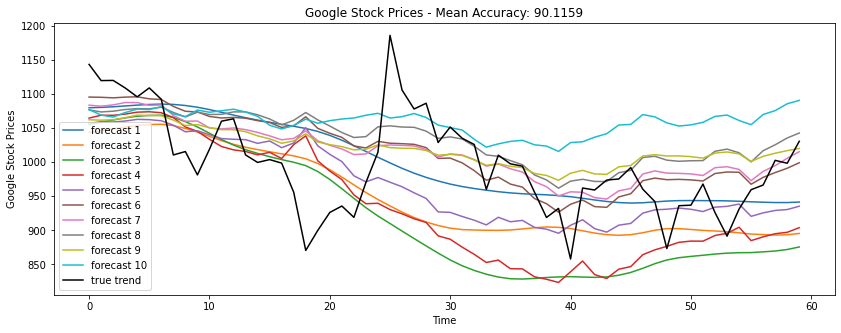

In [21]:
plt.figure(figsize=(14,5))
for i in range(simulation):
    plt.plot(result_forecast[i],label='forecast %d'%(i+1))
plt.plot(y_test,color='black',label='true trend')
plt.title('Google Stock Prices - Mean Accuracy: %.4f'%np.mean(mean_accuracy))
plt.xlabel('Time')
plt.ylabel('Google Stock Prices')
plt.legend()
plt.show()